In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'self-driving-cars:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786319%2F2903151%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T084023Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D07cd77bcbbdb021fba06f14eac06b66dccb101b099e5f9d30ed779cc09c0a0ff67b2b909594e3e96c59e74fae32a8fcb10ca0aaf1f8ed30c6c65b735b793cd725374deaff6e4775fc48eab749f514b504433ca0772d7e945f4cf41765bf03cc925b53ebf37e36a4eec115199ee5c50d7e9fefce5c047c56fb6accde64cfed70ecf3b1ce10db36043ed09d611f4120b3a6dd54a76fc67cef9da584cf9bfdf915c0a46b6e938bfe29a1baf4ff98dabde2cf3543c9ba92d23fb99508bfbc32a8e54f80b28ea02474044df08b81e0c3297bc6f82a2026f12baa5624b085aa52a30a6be261e3ae3a859c613519b3e4e2d45091014d064f7257d64f54536ec719f55a1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 935253372 bytes downloaded
Downloaded and uncompressed: self-driving-cars
Data source import complete.


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#9c7606; font-size:140%; text-align:left;padding: 10px; border-bottom: 2px solid #f79a05"> What is YOLO exactly?</p>

<div style="border-radius:10px; border:#f79a05 solid; padding: 15px; background-color: #f5d77f; font-size:100%; text-align:left">

<h3 align="left"><font color='black'>What is YOLO exactly?</font></h3>
    
**YOLO** (You Only Look Once) is a method / way to do object detection. It is the algorithm /strategy behind how the code is going to detect objects in the image.

Earlier detection frameworks, looked at different parts of the image multiple times at different scales and repurposed image classification technique to detect objects. This approach is slow and inefficient.

YOLO takes entirely different approach. It looks at the entire image only once and goes through the network once and detects objects. Hence the name. It is very fast. That’s the reason it has got so popular.

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#9c7606; font-size:140%; text-align:left;padding: 10px; border-bottom: 2px solid #f79a05"> Import Libraries</p>

In [2]:
import numpy as np
import pandas as pd
import cv2

from sklearn.utils import shuffle
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter('ignore')

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#9c7606; font-size:140%; text-align:left;padding: 10px; border-bottom: 2px solid #f79a05"> Load data</p>

In [3]:
df = pd.read_csv('../input/self-driving-cars/labels_train.csv')
df = shuffle(df)
df.head()

,frame,xmin,xmax,ymin,ymax,class_id
129656,1479505974989304530.jpg,304,317,140,153,1
94539,1479502669757083607.jpg,189,289,121,219,1
104158,1479503796334245817.jpg,46,61,111,122,1
87862,1479502141720325296.jpg,309,317,123,137,3
18213,1478732176435298557.jpg,124,132,91,105,5


<div style="border-radius:10px; border:#f79a05 solid; padding: 15px; background-color: #f5d77f; font-size:100%; text-align:left">
    
 * This dataset is mostly a practice and training aspect for the subject of YOLO. The data is labeled with 5 classes.
 * classic_id labels: 'car', 'truck', 'pedestrian', 'bicyclist', 'light'

In [4]:
classes = df.class_id.unique()
print(classes)

[1 3 5 2 4]


In [5]:
labels = { 1:'car', 2:'truck', 3:'person', 4:'bicycle', 5:'traffic light'}

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#9c7606; font-size:140%; text-align:left;padding: 10px; border-bottom: 2px solid #f79a05"> Show some labeled images</p>

In [6]:
# Get path images and boxes (x,y) for each class_id
boxes = {}
images = {}

base_path = '../input/self-driving-cars/images/'

for class_id in classes:
    first_row = df[df['class_id'] == class_id].iloc[0]

    images[class_id] = cv2.imread(base_path + first_row['frame'])
    boxes[class_id] = [first_row['xmin'],first_row['xmax'],first_row['ymin'],first_row['ymax']]

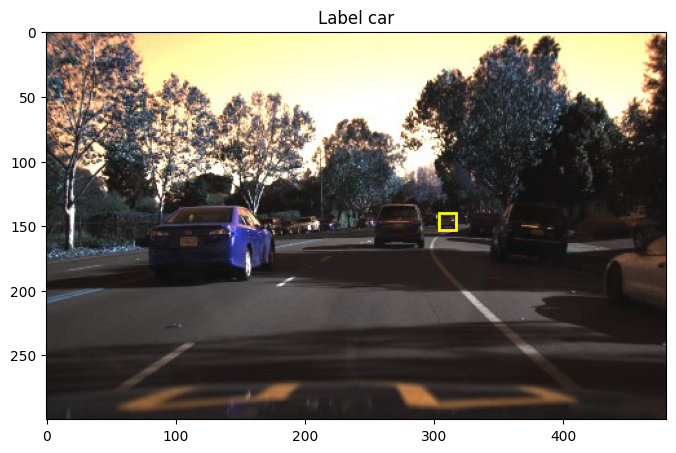

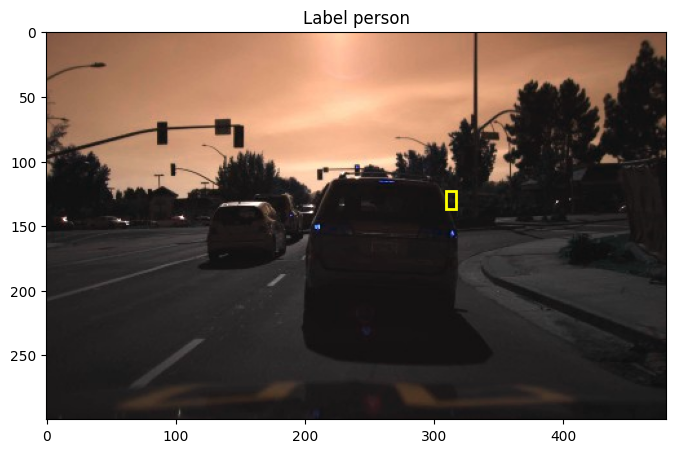

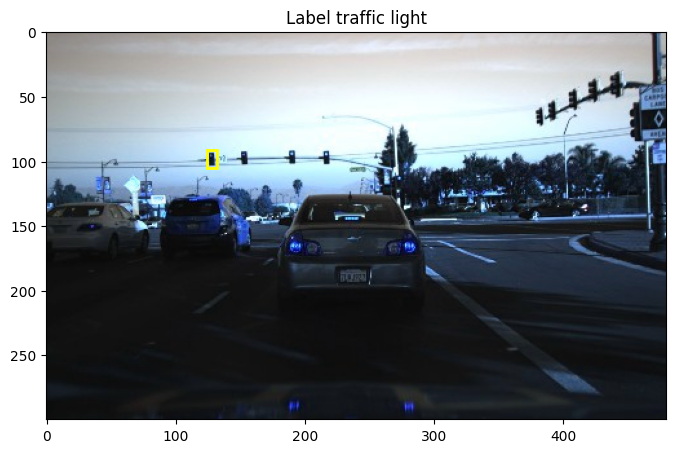

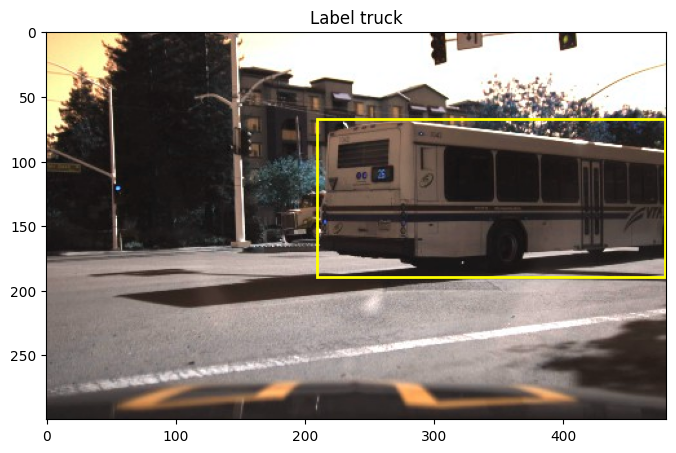

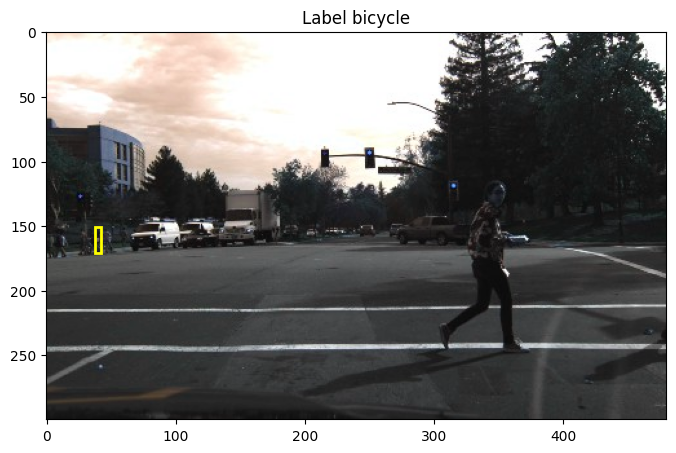

In [7]:
for i in classes:

    xmin, xmax, ymin, ymax = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]

    plt.figure(figsize=(8, 10))
    plt.title("Label " + labels[i])
    plt.imshow(images[i])
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='yellow', fill=False, linewidth=2))

    plt.show()

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#9c7606; font-size:140%; text-align:left;padding: 10px; border-bottom: 2px solid #f79a05"> Model</p>

In [8]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [9]:
from ultralytics import YOLO
import PIL
from PIL import Image
from IPython.display import display
import os
import pathlib

In [10]:
model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 177MB/s]


In [11]:
results=model.predict(source="/kaggle/input/self-driving-cars/images/1478019956680248165.jpg",
              save=True, conf=0.2,iou=0.5)


image 1/1 /kaggle/input/self-driving-cars/images/1478019956680248165.jpg: 416x640 1 car, 1 truck, 1861.5ms
Speed: 21.3ms preprocess, 1861.5ms inference, 4526.4ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict


In [12]:
result = results[0]
box = result.boxes[0]

In [13]:
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    probs = result.probs  # Class probabilities for classification outputs

In [14]:
cords = box.xyxy[0].tolist()
class_id = box.cls[0].item()
conf = box.conf[0].item()
print("Object type:", class_id)
print("Coordinates:", cords)
print("Probability:", conf)

Object type: 2.0
Coordinates: [124.69143676757812, 142.6882781982422, 148.7809295654297, 162.10047912597656]
Probability: 0.7161701321601868


In [15]:
for box in result.boxes:
    class_id = result.names[box.cls[0].item()]
    cords = box.xyxy[0].tolist()
    cords = [round(x) for x in cords]
    conf = round(box.conf[0].item(), 2)
    print("Object type:", class_id)
    print("Coordinates:", cords)
    print("Probability:", conf)
    print("---")

Object type: car
Coordinates: [125, 143, 149, 162]
Probability: 0.72
---
Object type: truck
Coordinates: [141, 139, 157, 154]
Probability: 0.31
---


In [16]:
results1 = model.predict(source="/kaggle/input/self-driving-cars/images/1478020211690815798.jpg",
              save=True, conf=0.2,iou=0.5)

Results = results1[0]


image 1/1 /kaggle/input/self-driving-cars/images/1478020211690815798.jpg: 416x640 4 cars, 3 traffic lights, 1831.0ms
Speed: 3.1ms preprocess, 1831.0ms inference, 15.4ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict


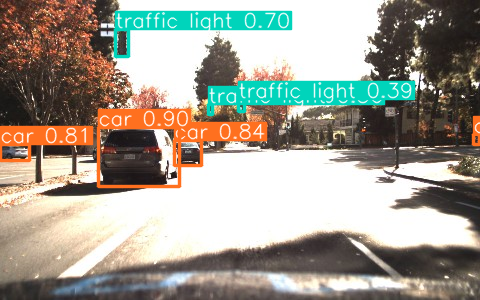

In [17]:
# Plotting results
plot = results1[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

In [19]:
import csv

# Open a CSV file to write the results
with open('object_detection_results.csv', 'w', newline='') as csvfile:
    fieldnames = ['Image', 'Object Type', 'X_min', 'Y_min', 'X_max', 'Y_max', 'Probability']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Loop through the results and write each detection to the CSV file
    for i, result in enumerate(results):
        image_name = f'image_{i+1}.jpg'
        for box in result.boxes:
            class_id = result.names[box.cls[0].item()]
            cords = box.xyxy[0].tolist()
            cords = [round(x) for x in cords]
            conf = round(box.conf[0].item(), 2)

            # Write the detection to the CSV file
            writer.writerow({'Image': image_name,
                             'Object Type': class_id,
                             'X_min': cords[0],
                             'Y_min': cords[1],
                             'X_max': cords[2],
                             'Y_max': cords[3],
                             'Probability': conf})

# Move the CSV file to the desired location
shutil.move('object_detection_results.csv', 'object_detection_results.csv')

'object_detection_results.csv'